<a href="https://colab.research.google.com/github/bhuvnk/EVA6/blob/main/Session%207%20Advanced%20Concepts/Session_07_Cifar10_69K_Submission.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Tue Jun 22 11:03:17 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
! pip install albumentations==0.4.6 -q

     |████████████████████████████████| 122kB 7.8MB/s 
     |████████████████████████████████| 952kB 13.3MB/s 


In [3]:
import albumentations
albumentations.__version__

'0.4.6'

In [4]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from torchsummary import summary

%matplotlib inline
import matplotlib.pyplot as plt
import pickle
import numpy as np

## YetAnotherDeepLearning Library

In [5]:
!git clone https://github.com/bhuvnk/EVA6.git
%cd "EVA6/Session 7 Advanced Concepts"
!pwd

Cloning into 'EVA6'...
remote: Enumerating objects: 285, done.
remote: Counting objects: 100% (285/285), done.
remote: Compressing objects: 100% (248/248), done.
remote: Total 285 (delta 131), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (285/285), 2.11 MiB | 16.04 MiB/s, done.
Resolving deltas: 100% (131/131), done.
/content/EVA6/Session 7 Advanced Concepts
/content/EVA6/Session 7 Advanced Concepts


In [6]:
## Importing stuff from YetAnotherDeepLearning Library
from yadl.data import get_dataloaders
from yadl.model import Net
from yadl.train import train, get_optimizer
from yadl.test import test
from yadl.utils import get_misclassified, plot_single, plot_multi

## Looking at the data

In [7]:
from yadl.data import Cifar10Dataset
from yadl.transformations import get_train_test_transforms


In [8]:
def train_data_details(cols=8, rows=5, transform=None):
  cifar10_ex = Cifar10Dataset('./data', train=True, download=True, transform=transform, viz=True )
  figure = plt.figure(figsize=(cols*1.5, rows*1.5))
  for i in range(1, cols * rows + 1):
    img, label = cifar10_ex[i]

    figure.add_subplot(rows, cols, i)
    plt.title(cifar10_ex.classes[label])
    plt.axis("off")
    # if transform is not None:
    #   plt.imshow(img.astype('uint8'))
    # else:
    plt.imshow(img, cmap="gray")

  plt.tight_layout()
  plt.show()
  if transform is None:
    print(' - mean:', np.mean(cifar10_ex.data, axis=(0,1,2)) / 255.)
    print(' - std:', np.std(cifar10_ex.data, axis=(0,1,2)) / 255.)
    print(' - var:', np.var(cifar10_ex.data, axis=(0,1,2)) / 255.)
  return cifar10_ex.classes



Extracting ./data/cifar-10-python.tar.gz to ./data


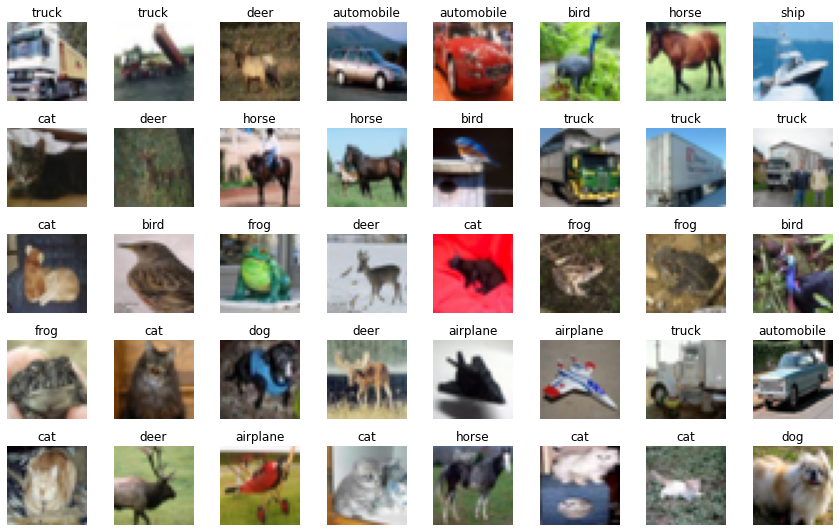

 - mean: [0.49139968 0.48215841 0.44653091]
 - std: [0.24703223 0.24348513 0.26158784]
 - var: [15.56135559 15.11767693 17.44919073]


In [9]:
classes = train_data_details()

In [10]:
classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

## After transformations and normalization

Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

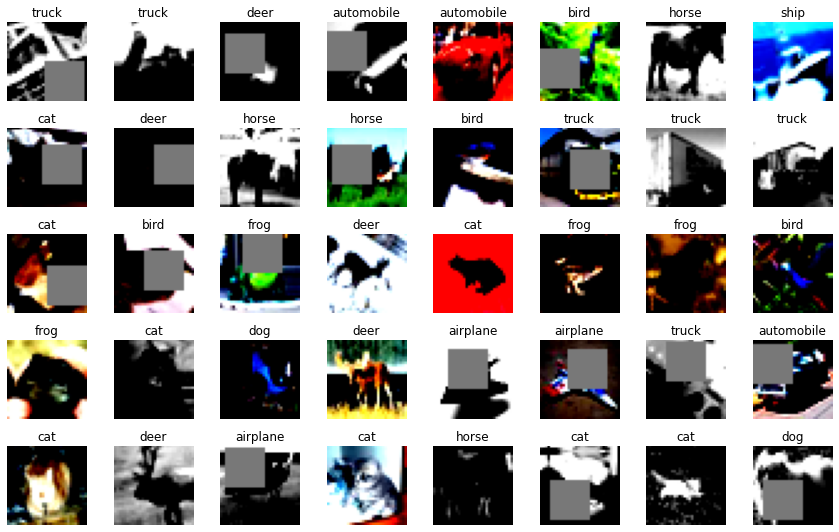

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [11]:
train_transforms, test_transforms = get_train_test_transforms()
train_data_details(transform=train_transforms)

In [12]:
# cifar10_ex.classes


## Trainer

In [13]:
EPOCHS = 20

SEED = 69
use_cuda = torch.cuda.is_available()

torch.manual_seed(SEED)
if use_cuda:
    torch.cuda.manual_seed(SEED)

device = torch.device("cuda" if use_cuda else "cpu")

In [14]:
def train_model(model, name, MAX_LR = 0.2, EPOCHS = 20, train_batch_size=128, val_batch_size=128, ):
  train_losses = []
  test_losses = []
  train_acc = []
  test_accs = []

  train_loader, test_loader = get_dataloaders(train_batch_size=train_batch_size,
                                              val_batch_size=val_batch_size,)

  print("*****A bit of Model Summary*****")
  summary(model, input_size=(3, 32, 32))

  wd = 0

  optimizer = get_optimizer(model.parameters(), lr=0.01, momentum=0.9, weight_decay=wd)

  scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, 
                                                max_lr=MAX_LR,
                                                steps_per_epoch=len(train_loader),
                                                epochs=EPOCHS) 

  print("*****Training Start*****")
  for epoch in range(EPOCHS):
      print('EPOCH {} and Learning Rate {}: '.format(epoch+1, scheduler.get_last_lr()))
      train_epoch_losses, train_epoch_acc = train(model, device, train_loader, optimizer, scheduler)
      test_loss, test_acc = test(model, device, test_loader)
      train_losses.extend(train_epoch_losses)
      train_acc.extend(train_epoch_acc)
      test_losses.append(test_loss)
      test_accs.append(test_acc)

  torch.save(model.state_dict(), f"{name}.pth")

  plot_single(name, train_losses, train_acc, test_losses, test_accs)
  return model, train_losses, test_losses, train_acc, test_accs

# Training and Stuff

Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
  0%|          | 0/782 [00:00<?, ?it/s]

*****A bit of Model Summary*****
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
              ReLU-2           [-1, 32, 32, 32]               0
       BatchNorm2d-3           [-1, 32, 32, 32]              64
            Conv2d-4           [-1, 32, 32, 32]             288
            Conv2d-5           [-1, 64, 32, 32]           2,048
              ReLU-6           [-1, 64, 32, 32]               0
       BatchNorm2d-7           [-1, 64, 32, 32]             128
            Conv2d-8           [-1, 32, 32, 32]           2,048
            Conv2d-9           [-1, 32, 32, 32]           9,216
             ReLU-10           [-1, 32, 32, 32]               0
      BatchNorm2d-11           [-1, 32, 32, 32]              64
           Conv2d-12           [-1, 32, 32, 32]             288
           Conv2d-13           [-1, 64, 32, 32]           2,048
      

Loss=1.5632771253585815 Batch_id=781 Accuracy=36.75: 100%|██████████| 782/782 [00:27<00:00, 28.09it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.2729, Accuracy: 5428/10000 (54.28%)

EPOCH 2 and Learning Rate [0.008821380710680227]: 


Loss=1.5939674377441406 Batch_id=781 Accuracy=47.87: 100%|██████████| 782/782 [00:27<00:00, 28.01it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.1371, Accuracy: 5904/10000 (59.04%)

EPOCH 3 and Learning Rate [0.011271467295390108]: 


Loss=1.2952697277069092 Batch_id=781 Accuracy=52.12: 100%|██████████| 782/782 [00:27<00:00, 28.39it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.0132, Accuracy: 6398/10000 (63.98%)

EPOCH 4 and Learning Rate [0.015308333632042648]: 


Loss=1.097843050956726 Batch_id=781 Accuracy=54.90: 100%|██████████| 782/782 [00:28<00:00, 27.92it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.0443, Accuracy: 6477/10000 (64.77%)

EPOCH 5 and Learning Rate [0.020862900467710305]: 


Loss=1.2151076793670654 Batch_id=781 Accuracy=57.24: 100%|██████████| 782/782 [00:27<00:00, 28.23it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8803, Accuracy: 6914/10000 (69.14%)

EPOCH 6 and Learning Rate [0.02784011750958057]: 


Loss=1.608498454093933 Batch_id=781 Accuracy=58.72: 100%|██████████| 782/782 [00:27<00:00, 28.16it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.9991, Accuracy: 6620/10000 (66.20%)

EPOCH 7 and Learning Rate [0.036120589934894615]: 


Loss=1.0433412790298462 Batch_id=781 Accuracy=59.89: 100%|██████████| 782/782 [00:27<00:00, 28.51it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8390, Accuracy: 7117/10000 (71.17%)

EPOCH 8 and Learning Rate [0.04556262148687182]: 


Loss=0.895369827747345 Batch_id=781 Accuracy=61.17: 100%|██████████| 782/782 [00:27<00:00, 28.00it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8829, Accuracy: 7023/10000 (70.23%)

EPOCH 9 and Learning Rate [0.05600463919496154]: 


Loss=1.0466307401657104 Batch_id=781 Accuracy=61.87: 100%|██████████| 782/782 [00:27<00:00, 28.24it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7391, Accuracy: 7404/10000 (74.04%)

EPOCH 10 and Learning Rate [0.06726795822737208]: 


Loss=0.9400968551635742 Batch_id=781 Accuracy=62.92: 100%|██████████| 782/782 [00:27<00:00, 28.12it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7402, Accuracy: 7449/10000 (74.49%)

EPOCH 11 and Learning Rate [0.07915983956344792]: 


Loss=0.8519269227981567 Batch_id=781 Accuracy=63.88: 100%|██████████| 782/782 [00:27<00:00, 28.10it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7567, Accuracy: 7454/10000 (74.54%)

EPOCH 12 and Learning Rate [0.09147678816270682]: 


Loss=1.352637529373169 Batch_id=781 Accuracy=64.80: 100%|██████████| 782/782 [00:28<00:00, 27.83it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7317, Accuracy: 7513/10000 (75.13%)

EPOCH 13 and Learning Rate [0.10400803519194311]: 


Loss=0.6895068883895874 Batch_id=781 Accuracy=65.19: 100%|██████████| 782/782 [00:27<00:00, 28.07it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7913, Accuracy: 7346/10000 (73.46%)

EPOCH 14 and Learning Rate [0.1165391447221863]: 


Loss=0.5294829607009888 Batch_id=781 Accuracy=65.93: 100%|██████████| 782/782 [00:27<00:00, 28.04it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7124, Accuracy: 7576/10000 (75.76%)

EPOCH 15 and Learning Rate [0.12885568317736218]: 


Loss=0.9526227116584778 Batch_id=781 Accuracy=66.26: 100%|██████████| 782/782 [00:27<00:00, 28.26it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6641, Accuracy: 7741/10000 (77.41%)

EPOCH 16 and Learning Rate [0.14074688874269087]: 


Loss=0.9898002743721008 Batch_id=781 Accuracy=66.87: 100%|██████████| 782/782 [00:27<00:00, 28.24it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6744, Accuracy: 7716/10000 (77.16%)

EPOCH 17 and Learning Rate [0.1520092779415454]: 


Loss=0.920019268989563 Batch_id=781 Accuracy=67.08: 100%|██████████| 782/782 [00:27<00:00, 27.96it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7282, Accuracy: 7592/10000 (75.92%)

EPOCH 18 and Learning Rate [0.1624501276646735]: 


Loss=0.8961501717567444 Batch_id=781 Accuracy=67.22: 100%|██████████| 782/782 [00:27<00:00, 28.17it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6461, Accuracy: 7756/10000 (77.56%)

EPOCH 19 and Learning Rate [0.17189077306695658]: 


Loss=1.090470552444458 Batch_id=781 Accuracy=68.03: 100%|██████████| 782/782 [00:28<00:00, 27.87it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6390, Accuracy: 7836/10000 (78.36%)

EPOCH 20 and Learning Rate [0.18016966489777372]: 


Loss=1.200011134147644 Batch_id=781 Accuracy=68.28: 100%|██████████| 782/782 [00:27<00:00, 28.15it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6705, Accuracy: 7702/10000 (77.02%)

EPOCH 21 and Learning Rate [0.18714513394763235]: 


Loss=1.014909267425537 Batch_id=781 Accuracy=68.42: 100%|██████████| 782/782 [00:28<00:00, 27.87it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5936, Accuracy: 8025/10000 (80.25%)

EPOCH 22 and Learning Rate [0.19269781530558455]: 


Loss=1.32050621509552 Batch_id=781 Accuracy=68.95: 100%|██████████| 782/782 [00:27<00:00, 28.04it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6629, Accuracy: 7782/10000 (77.82%)

EPOCH 23 and Learning Rate [0.1967326909432975]: 


Loss=0.7059261798858643 Batch_id=781 Accuracy=69.29: 100%|██████████| 782/782 [00:28<00:00, 27.86it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6114, Accuracy: 7987/10000 (79.87%)

EPOCH 24 and Learning Rate [0.1991807156728793]: 


Loss=0.5064981579780579 Batch_id=781 Accuracy=69.87: 100%|██████████| 782/782 [00:27<00:00, 27.97it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5564, Accuracy: 8059/10000 (80.59%)

EPOCH 25 and Learning Rate [0.1999999997426771]: 


Loss=0.7972041368484497 Batch_id=781 Accuracy=69.79: 100%|██████████| 782/782 [00:27<00:00, 28.05it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5709, Accuracy: 8071/10000 (80.71%)

EPOCH 26 and Learning Rate [0.19984227963217474]: 


Loss=1.169491171836853 Batch_id=781 Accuracy=70.62: 100%|██████████| 782/782 [00:28<00:00, 27.90it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5580, Accuracy: 8127/10000 (81.27%)

EPOCH 27 and Learning Rate [0.19937042003041172]: 


Loss=0.557719349861145 Batch_id=781 Accuracy=70.52: 100%|██████████| 782/782 [00:27<00:00, 28.05it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5478, Accuracy: 8106/10000 (81.06%)

EPOCH 28 and Learning Rate [0.1985859055822665]: 


Loss=0.8919439911842346 Batch_id=781 Accuracy=70.47: 100%|██████████| 782/782 [00:27<00:00, 28.04it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5381, Accuracy: 8160/10000 (81.60%)

EPOCH 29 and Learning Rate [0.19749120466043535]: 


Loss=0.7284324169158936 Batch_id=781 Accuracy=71.11: 100%|██████████| 782/782 [00:28<00:00, 27.89it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5387, Accuracy: 8162/10000 (81.62%)

EPOCH 30 and Learning Rate [0.1960897615990186]: 


Loss=0.730898916721344 Batch_id=781 Accuracy=71.06: 100%|██████████| 782/782 [00:28<00:00, 27.61it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5392, Accuracy: 8145/10000 (81.45%)

EPOCH 31 and Learning Rate [0.19438598585637154]: 


Loss=1.245057463645935 Batch_id=781 Accuracy=71.45: 100%|██████████| 782/782 [00:28<00:00, 27.84it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5225, Accuracy: 8208/10000 (82.08%)

EPOCH 32 and Learning Rate [0.19238523814131678]: 


Loss=1.2158550024032593 Batch_id=781 Accuracy=71.28: 100%|██████████| 782/782 [00:28<00:00, 27.79it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5389, Accuracy: 8192/10000 (81.92%)

EPOCH 33 and Learning Rate [0.19009381354637134]: 


Loss=0.6355012655258179 Batch_id=781 Accuracy=72.05: 100%|██████████| 782/782 [00:27<00:00, 27.93it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5601, Accuracy: 8107/10000 (81.07%)

EPOCH 34 and Learning Rate [0.18751892174105628]: 


Loss=0.5728664398193359 Batch_id=781 Accuracy=71.84: 100%|██████████| 782/782 [00:27<00:00, 27.93it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5346, Accuracy: 8197/10000 (81.97%)

EPOCH 35 and Learning Rate [0.1846686642876094]: 


Loss=1.2809367179870605 Batch_id=781 Accuracy=72.25: 100%|██████████| 782/782 [00:28<00:00, 27.86it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5451, Accuracy: 8197/10000 (81.97%)

EPOCH 36 and Learning Rate [0.18155200915047287]: 


Loss=0.7588520646095276 Batch_id=781 Accuracy=72.48: 100%|██████████| 782/782 [00:27<00:00, 28.00it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5845, Accuracy: 8038/10000 (80.38%)

EPOCH 37 and Learning Rate [0.17817876247975953]: 


Loss=1.3905500173568726 Batch_id=781 Accuracy=72.55: 100%|██████████| 782/782 [00:28<00:00, 27.87it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5309, Accuracy: 8238/10000 (82.38%)

EPOCH 38 and Learning Rate [0.17455953775747649]: 


Loss=0.3755852282047272 Batch_id=781 Accuracy=72.91: 100%|██████████| 782/782 [00:27<00:00, 28.06it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5556, Accuracy: 8206/10000 (82.06%)

EPOCH 39 and Learning Rate [0.17070572240358423]: 


Loss=0.6118614673614502 Batch_id=781 Accuracy=72.74: 100%|██████████| 782/782 [00:28<00:00, 27.88it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4834, Accuracy: 8324/10000 (83.24%)

EPOCH 40 and Learning Rate [0.16662944194696044]: 


Loss=0.7802290916442871 Batch_id=781 Accuracy=72.92: 100%|██████████| 782/782 [00:28<00:00, 27.92it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5206, Accuracy: 8249/10000 (82.49%)

EPOCH 41 and Learning Rate [0.1623435218740002]: 


Loss=0.4372637867927551 Batch_id=781 Accuracy=73.15: 100%|██████████| 782/782 [00:28<00:00, 27.74it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5136, Accuracy: 8279/10000 (82.79%)

EPOCH 42 and Learning Rate [0.15786144727489076]: 


Loss=0.5461710691452026 Batch_id=781 Accuracy=73.34: 100%|██████████| 782/782 [00:28<00:00, 27.73it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5389, Accuracy: 8185/10000 (81.85%)

EPOCH 43 and Learning Rate [0.15319732041452877]: 


Loss=0.7714287638664246 Batch_id=781 Accuracy=73.52: 100%|██████████| 782/782 [00:28<00:00, 27.82it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5350, Accuracy: 8235/10000 (82.35%)

EPOCH 44 and Learning Rate [0.14836581636157772]: 


Loss=0.5772411823272705 Batch_id=781 Accuracy=73.84: 100%|██████████| 782/782 [00:28<00:00, 27.90it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5004, Accuracy: 8327/10000 (83.27%)

EPOCH 45 and Learning Rate [0.14338213681527248]: 


Loss=0.977296769618988 Batch_id=781 Accuracy=73.84: 100%|██████████| 782/782 [00:28<00:00, 27.84it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4803, Accuracy: 8367/10000 (83.67%)

EPOCH 46 and Learning Rate [0.13826196227524962]: 


Loss=0.8136401176452637 Batch_id=781 Accuracy=74.02: 100%|██████████| 782/782 [00:28<00:00, 27.88it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5006, Accuracy: 8321/10000 (83.21%)

EPOCH 47 and Learning Rate [0.13302140270489415]: 


Loss=1.080115795135498 Batch_id=781 Accuracy=74.21: 100%|██████████| 782/782 [00:28<00:00, 27.52it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5178, Accuracy: 8269/10000 (82.69%)

EPOCH 48 and Learning Rate [0.1276769468434347]: 


Loss=0.7726026177406311 Batch_id=781 Accuracy=74.27: 100%|██████████| 782/782 [00:28<00:00, 27.54it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4567, Accuracy: 8433/10000 (84.33%)

EPOCH 49 and Learning Rate [0.12224541032626969]: 


Loss=1.1580755710601807 Batch_id=781 Accuracy=74.69: 100%|██████████| 782/782 [00:28<00:00, 27.31it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5675, Accuracy: 8088/10000 (80.88%)

EPOCH 50 and Learning Rate [0.11674388277675708]: 


Loss=0.7106693983078003 Batch_id=781 Accuracy=74.30: 100%|██████████| 782/782 [00:28<00:00, 27.54it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5073, Accuracy: 8302/10000 (83.02%)

EPOCH 51 and Learning Rate [0.1111896740359368]: 


Loss=1.303449034690857 Batch_id=781 Accuracy=74.58: 100%|██████████| 782/782 [00:28<00:00, 27.45it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5030, Accuracy: 8334/10000 (83.34%)

EPOCH 52 and Learning Rate [0.10560025969936676]: 


Loss=0.48346903920173645 Batch_id=781 Accuracy=74.56: 100%|██████████| 782/782 [00:28<00:00, 27.43it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4606, Accuracy: 8427/10000 (84.27%)

EPOCH 53 and Learning Rate [0.09999322613243396]: 


Loss=0.8967224955558777 Batch_id=781 Accuracy=74.95: 100%|██████████| 782/782 [00:28<00:00, 27.30it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4713, Accuracy: 8408/10000 (84.08%)

EPOCH 54 and Learning Rate [0.09438621513714264]: 


Loss=1.1772425174713135 Batch_id=781 Accuracy=75.28: 100%|██████████| 782/782 [00:28<00:00, 27.57it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4718, Accuracy: 8421/10000 (84.21%)

EPOCH 55 and Learning Rate [0.08879686844447815]: 


Loss=1.0098850727081299 Batch_id=781 Accuracy=75.40: 100%|██████████| 782/782 [00:28<00:00, 27.15it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4453, Accuracy: 8484/10000 (84.84%)

EPOCH 56 and Learning Rate [0.0832427722069948]: 


Loss=0.8136069774627686 Batch_id=781 Accuracy=75.56: 100%|██████████| 782/782 [00:28<00:00, 27.20it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4472, Accuracy: 8478/10000 (84.78%)

EPOCH 57 and Learning Rate [0.07774140166627344]: 


Loss=0.7312231063842773 Batch_id=781 Accuracy=75.78: 100%|██████████| 782/782 [00:28<00:00, 27.35it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4798, Accuracy: 8383/10000 (83.83%)

EPOCH 58 and Learning Rate [0.07231006616934618]: 


Loss=0.7279257774353027 Batch_id=781 Accuracy=75.69: 100%|██████████| 782/782 [00:28<00:00, 27.34it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4563, Accuracy: 8446/10000 (84.46%)

EPOCH 59 and Learning Rate [0.066965854707087]: 


Loss=0.9338326454162598 Batch_id=781 Accuracy=75.88: 100%|██████████| 782/782 [00:28<00:00, 27.01it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4524, Accuracy: 8495/10000 (84.95%)

EPOCH 60 and Learning Rate [0.06172558214592398]: 


Loss=1.0014599561691284 Batch_id=781 Accuracy=76.43: 100%|██████████| 782/782 [00:28<00:00, 27.31it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4308, Accuracy: 8527/10000 (85.27%)

EPOCH 61 and Learning Rate [0.056605736322048614]: 


Loss=0.5138049721717834 Batch_id=781 Accuracy=76.56: 100%|██████████| 782/782 [00:28<00:00, 27.00it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4277, Accuracy: 8533/10000 (85.33%)

EPOCH 62 and Learning Rate [0.05162242616458335]: 


Loss=1.0024809837341309 Batch_id=781 Accuracy=76.73: 100%|██████████| 782/782 [00:28<00:00, 27.10it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4227, Accuracy: 8566/10000 (85.66%)

EPOCH 63 and Learning Rate [0.04679133101093077]: 


Loss=0.8985968828201294 Batch_id=781 Accuracy=76.86: 100%|██████████| 782/782 [00:28<00:00, 27.24it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4235, Accuracy: 8577/10000 (85.77%)

EPOCH 64 and Learning Rate [0.04212765127377732]: 


Loss=1.1503372192382812 Batch_id=781 Accuracy=77.01: 100%|██████████| 782/782 [00:28<00:00, 27.13it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4197, Accuracy: 8585/10000 (85.85%)

EPOCH 65 and Learning Rate [0.037646060614971416]: 


Loss=1.0940296649932861 Batch_id=781 Accuracy=77.31: 100%|██████████| 782/782 [00:28<00:00, 27.19it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4157, Accuracy: 8588/10000 (85.88%)

EPOCH 66 and Learning Rate [0.03336065977675451]: 


Loss=0.5551171898841858 Batch_id=781 Accuracy=77.58: 100%|██████████| 782/782 [00:28<00:00, 27.14it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4119, Accuracy: 8594/10000 (85.94%)

EPOCH 67 and Learning Rate [0.029284932215609218]: 


Loss=1.109018325805664 Batch_id=781 Accuracy=77.61: 100%|██████████| 782/782 [00:29<00:00, 26.95it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4043, Accuracy: 8640/10000 (86.40%)

EPOCH 68 and Learning Rate [0.02543170167831689]: 


Loss=0.6800676584243774 Batch_id=781 Accuracy=77.98: 100%|██████████| 782/782 [00:28<00:00, 27.18it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4030, Accuracy: 8644/10000 (86.44%)

EPOCH 69 and Learning Rate [0.021813091853705845]: 


Loss=0.5159005522727966 Batch_id=781 Accuracy=77.93: 100%|██████████| 782/782 [00:28<00:00, 27.11it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.3975, Accuracy: 8680/10000 (86.80%)

EPOCH 70 and Learning Rate [0.018440488227041]: 


Loss=0.3999071717262268 Batch_id=781 Accuracy=78.29: 100%|██████████| 782/782 [00:28<00:00, 27.37it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4006, Accuracy: 8652/10000 (86.52%)

EPOCH 71 and Learning Rate [0.015324502257075004]: 


Loss=0.8166183829307556 Batch_id=781 Accuracy=78.21: 100%|██████████| 782/782 [00:28<00:00, 27.07it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.3981, Accuracy: 8670/10000 (86.70%)

EPOCH 72 and Learning Rate [0.012474937988473146]: 


Loss=0.3190598785877228 Batch_id=781 Accuracy=78.63: 100%|██████████| 782/782 [00:28<00:00, 27.16it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4006, Accuracy: 8668/10000 (86.68%)

EPOCH 73 and Learning Rate [0.009900761204661693]: 


Loss=0.7743849754333496 Batch_id=781 Accuracy=78.86: 100%|██████████| 782/782 [00:28<00:00, 27.13it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.3923, Accuracy: 8685/10000 (86.85%)

EPOCH 74 and Learning Rate [0.007610071218156189]: 


Loss=0.2570918798446655 Batch_id=781 Accuracy=79.17: 100%|██████████| 782/782 [00:28<00:00, 27.12it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.3973, Accuracy: 8675/10000 (86.75%)

EPOCH 75 and Learning Rate [0.005610075387127873]: 


Loss=0.8765673041343689 Batch_id=781 Accuracy=79.14: 100%|██████████| 782/782 [00:28<00:00, 27.22it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.3861, Accuracy: 8710/10000 (87.10%)

EPOCH 76 and Learning Rate [0.003907066438388321]: 


Loss=0.6855331659317017 Batch_id=781 Accuracy=79.15: 100%|██████████| 782/782 [00:29<00:00, 26.93it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.3808, Accuracy: 8722/10000 (87.22%)

EPOCH 77 and Learning Rate [0.0025064026681429217]: 


Loss=0.4962536692619324 Batch_id=781 Accuracy=79.20: 100%|██████████| 782/782 [00:29<00:00, 26.93it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.3789, Accuracy: 8734/10000 (87.34%)

EPOCH 78 and Learning Rate [0.0014124910828085392]: 


Loss=0.24698226153850555 Batch_id=781 Accuracy=79.39: 100%|██████████| 782/782 [00:28<00:00, 27.31it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.3794, Accuracy: 8715/10000 (87.15%)

EPOCH 79 and Learning Rate [0.0006287735329409451]: 


Loss=0.5065107345581055 Batch_id=781 Accuracy=79.39: 100%|██████████| 782/782 [00:28<00:00, 26.99it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.3780, Accuracy: 8726/10000 (87.26%)

EPOCH 80 and Learning Rate [0.00015771588389959499]: 


Loss=0.48169535398483276 Batch_id=781 Accuracy=79.49: 100%|██████████| 782/782 [00:28<00:00, 27.03it/s]



Test set: Average loss: 0.3847, Accuracy: 8712/10000 (87.12%)



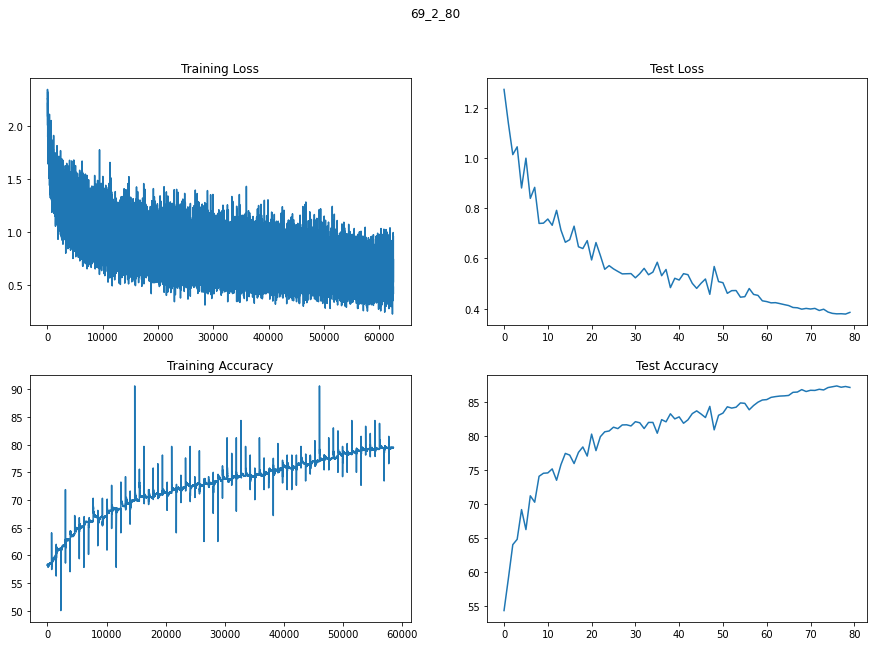

In [15]:
model =  Net().to(device)

model, train_losses, test_losses, train_acc, test_accs = train_model(model, "69_2_80", 
                                                                     MAX_LR = 0.2, EPOCHS = 80,
                                                                     train_batch_size = 64,
                                                                     val_batch_size = 64)

Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integ

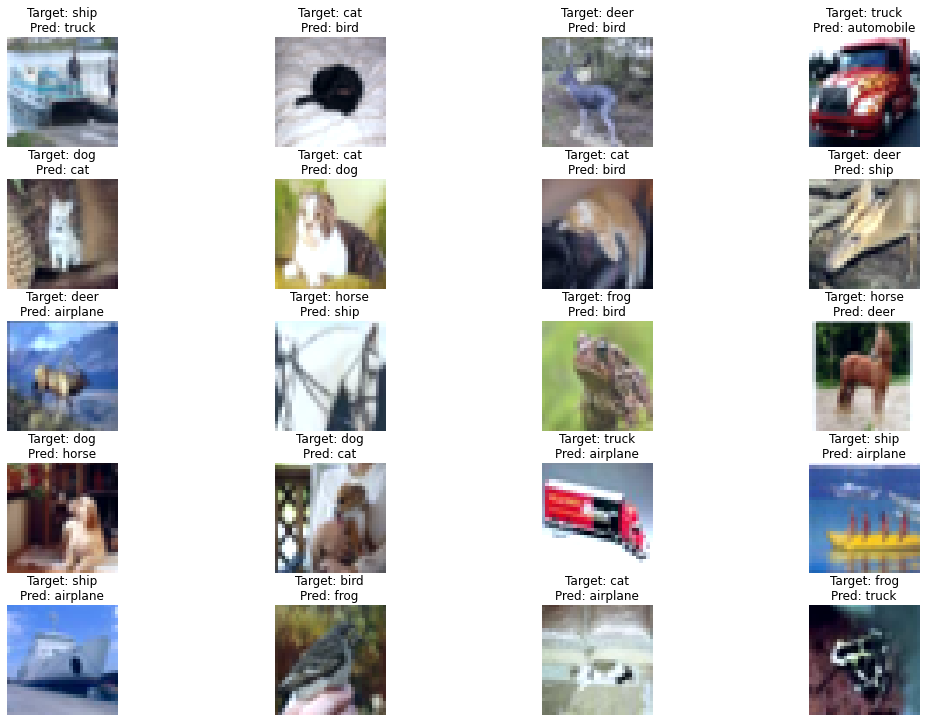

In [16]:
get_misclassified(model, "69_2_80", classes)
